In [2]:
import pandas as pd
import os
import math
import re
from collections import Counter
from scipy import stats

import nltk
import yaml

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saraho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Generate Unlabeled Data

In [5]:
datadir = '../data/daily'
all_df = []

for file in os.listdir(datadir):
    if 'joined' in file: 
        df = pd.read_csv(datadir + '/' + file)
        all_df.append(df)

data = pd.concat(all_df)
data = data[['news_id', 'wiki_id', 'date', 'news', 'entity', 'title', 'wiki']]
data = data.sort_values(['date', 'news_id', 'wiki_id'])
data.to_csv('../data/unlabeled_data.csv')

# Evaluate Labeled Data

In [3]:
labeled = pd.read_csv('../data/labeled/labeled_data.csv')
labeled = labeled.dropna()
labeled.head()

,news_id,wiki_id,date,news,entity,title,wiki,label
0,1,0,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,GOP (organization),Republican Party (United States),"The Republican Party, also referred to as the ...",1
1,1,1,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,Allen West,Allen West (politician),"Allen Bernard West (born February 7, 1961) is ...",1
2,1,2,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,the Texas Republican Party (organization),Republican Party of Texas,The Republican Party of Texas (RPT) is the aff...,1
3,3,3,Jun-04-2021,China's deadly Tiananmen crackdown remembered ...,Tiananmen Square,Tiananmen Square,"Tiananmen Square or Tian'anmen Square (; 天安门, ...",1
4,4,4,Jun-04-2021,Republicans draw inspiration from problem-plag...,Republicans,Republican,Republican can refer to:\n\n\n,0


In [4]:
def remove_stopwords(df, c):

    stop_words = stopwords.words('english')
    for raw, processed in zip(c['raw_features'], c['processed_features']):
        df[processed] = df[raw].str.lower().str.split(). \
            apply(lambda x: ' '.join([item for item in x
                                      if item not in stop_words]))
    return df

stop_words = stopwords.words('english')

with open('../config/algorithm.yaml', 'r') as f:
    c = yaml.load(f, Loader=yaml.FullLoader)

for raw, processed in zip(c['raw_features'], c['processed_features']):
    labeled[processed] = labeled[raw].str.lower().str.split(). \
        apply(lambda x: ' '.join([item for item in x
                                  if item not in stop_words]))

labeled = labeled.dropna()
labeled = remove_stopwords(labeled, c)
labeled.head()

,news_id,wiki_id,date,news,entity,title,wiki,label,wiki_process,news_process
0,1,0,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,GOP (organization),Republican Party (United States),"The Republican Party, also referred to as the ...",1,"republican party, also referred gop (""grand ol...",texas gop chair allen west resigns - allen wes...
1,1,1,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,Allen West,Allen West (politician),"Allen Bernard West (born February 7, 1961) is ...",1,"allen bernard west (born february 7, 1961) ame...",texas gop chair allen west resigns - allen wes...
2,1,2,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,the Texas Republican Party (organization),Republican Party of Texas,The Republican Party of Texas (RPT) is the aff...,1,republican party texas (rpt) affiliate united ...,texas gop chair allen west resigns - allen wes...
3,3,3,Jun-04-2021,China's deadly Tiananmen crackdown remembered ...,Tiananmen Square,Tiananmen Square,"Tiananmen Square or Tian'anmen Square (; 天安门, ...",1,"tiananmen square tian'anmen square (; 天安门, pin...",china's deadly tiananmen crackdown remembered ...
4,4,4,Jun-04-2021,Republicans draw inspiration from problem-plag...,Republicans,Republican,Republican can refer to:\n\n\n,0,republican refer to:,republicans draw inspiration problem-plagued a...


In [5]:
def sim_sm(x):
    from difflib import SequenceMatcher
    return SequenceMatcher(None, x[0], x[1]).ratio()


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    WORD = re.compile(r"\w+")
    words = WORD.findall(text)
    return Counter(words)


def cos_pipeline(x):
    vector1 = text_to_vector(x[0])
    vector2 = text_to_vector(x[1])

    return get_cosine(vector1, vector2)


<AxesSubplot:>

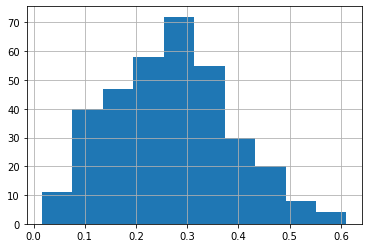

In [6]:
labeled['cos_sim'] = labeled[['wiki', 'news']].apply(cos_pipeline, axis=1)
labeled['cos_sim'].hist()

<AxesSubplot:>

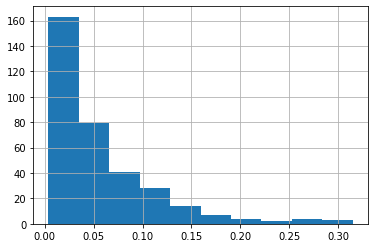

In [7]:
labeled['sm_sim'] = labeled[['wiki', 'news']].apply(sim_sm, axis=1)
labeled['sm_sim'].hist()

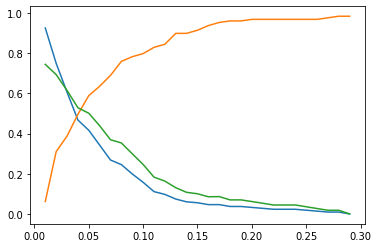

In [8]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt

sensitivities = []
specificities = []
f1s = []
aucs = []
accuracies = []

cutoffs = np.arange(0.01, 0.3, 0.01)
for cutoff in cutoffs:

    labeled['predict'] = labeled['sm_sim'] > cutoff
    labeled['predict'] = labeled['predict'].astype(int)

    cm1 = confusion_matrix(labeled['label'], labeled['predict'])
    total1=sum(sum(cm1))

    ### from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    accuracies.append(accuracy1)
    
    # true positives
    sensitivity1 = cm1[0,0]/(cm1[0,0] + cm1[0,1])
    sensitivities.append(sensitivity1)

    # true negatives
    specificity1 = cm1[1,1]/(cm1[1,0] + cm1[1,1])
    specificities.append(specificity1)

    auc = roc_auc_score(labeled['label'], labeled['predict'])
    aucs.append(auc)

    f1s.append(f1_score(labeled['label'], labeled['predict']))
    
plt.plot(cutoffs, specificities)
plt.plot(cutoffs, sensitivities)
plt.plot(cutoffs, f1s)
plt.show()

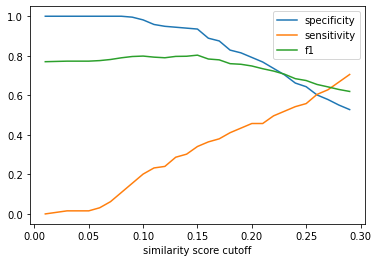

In [11]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt

sensitivities = []
specificities = []
f1s = []
aucs = []
accuracies = []

cutoffs = np.arange(0.01, 0.3, 0.01)
for cutoff in cutoffs:

    labeled['predict'] = labeled['cos_sim'] > cutoff
    labeled['predict'] = labeled['predict'].astype(int)

    cm1 = confusion_matrix(labeled['label'], labeled['predict'])
    total1=sum(sum(cm1))

    ### from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    accuracies.append(accuracy1)
    
    # true positives
    sensitivity1 = cm1[0,0]/(cm1[0,0] + cm1[0,1])
    sensitivities.append(sensitivity1)

    # true negatives
    specificity1 = cm1[1,1]/(cm1[1,0] + cm1[1,1])
    specificities.append(specificity1)

    auc = roc_auc_score(labeled['label'], labeled['predict'])
    aucs.append(auc)

    f1s.append(f1_score(labeled['label'], labeled['predict']))
    
plt.plot(cutoffs, specificities, label='specificity')
plt.plot(cutoffs, sensitivities, label='sensitivity')
plt.plot(cutoffs, f1s, label='f1')
plt.xlabel("similarity score cutoff")
plt.legend()
plt.show()

In [16]:
maxpos = np.argmax(f1s)
print(np.max(f1s), cutoffs[maxpos])

0.74487895716946 0.01


In [17]:
labeled['predict'] = (labeled['sm_sim'] > 0.1)
labeled.loc[labeled['predict']]['label'].value_counts()

1    34
0    26
Name: label, dtype: int64

In [23]:
labeled['predict'] = (labeled['cos_sim'] > 0.25)
labeled.loc[labeled['predict']]['label'].value_counts()

1    171
0     70
Name: label, dtype: int64

In [18]:
labeled.drop_duplicates(['news_id', 'title']).loc[labeled['predict']].head()

,news_id,wiki_id,date,news,entity,title,wiki,label,wiki_process,news_process,cos_sim,sm_sim,predict
0,1,0,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,GOP (organization),Republican Party (United States),"The Republican Party, also referred to as the ...",1,"republican party, also referred gop (""grand ol...",texas gop chair allen west resigns - allen wes...,0.365486,0.108631,True
1,1,1,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,Allen West,Allen West (politician),"Allen Bernard West (born February 7, 1961) is ...",1,"allen bernard west (born february 7, 1961) ame...",texas gop chair allen west resigns - allen wes...,0.487826,0.129528,True
2,1,2,Jun-04-2021,Texas GOP chair Allen West resigns - Allen ...,the Texas Republican Party (organization),Republican Party of Texas,The Republican Party of Texas (RPT) is the aff...,1,republican party texas (rpt) affiliate united ...,texas gop chair allen west resigns - allen wes...,0.371338,0.283814,True
16,9,16,Jun-04-2021,CDC Director 'Deeply Concerned' By Teen COVID-...,CDC (organization),CDC,CDC may refer to:,0,cdc may refer to:,cdc director 'deeply concerned' teen covid-19 ...,0.089803,0.126829,True
17,9,17,Jun-04-2021,CDC Director 'Deeply Concerned' By Teen COVID-...,Hospitalization Rate -,Shingles,"Shingles, also known as zoster or herpes zoste...",0,"shingles, also known zoster herpes zoster, vir...",cdc director 'deeply concerned' teen covid-19 ...,0.229711,0.142125,True


In [7]:
from gensim.models import Word2Vec
model = Word2Vec(sentences, min_count=1)
model.similarity('france', 'spain')

NameError: name 'sentences' is not defined